In [67]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#from scipy.stats import norm
#from scipy.stats import linregress
#import statsmodels.formula.api as smf
import csv
import scipy.optimize as opt
import pandas_datareader as pdr
from datetime import datetime

In [68]:
# function to read in data from a csv
def readPricesCSV(file):
    df = pd.read_csv(file)
    dfPrices = df["Adj Close"]
    return dfPrices

In [69]:
# function to read in stock prices from yahoo finance
def readPricesYF(start_date, end_date, tickers):
    stockPrices = pdr.get_data_yahoo(tickers, start=start_date, end=end_date)   # read in the data
    stockPrices = stockPrices.filter(like='Adj Close')   # tickers are columns and data values are adjusted closing prices with the date as the index
    stockPrices.columns = tickers   # change column names to be their tickers
    stockPrices = stockPrices.stack().swaplevel().sort_index().reset_index()    # make the data tall and clean it up so it is easier to perform analysis on
    stockPrices.columns = ['Firm','Date','Adj Close']     # rename the columns
#    stockPrices['Return'] = stockPrices.groupby('Firm')['Adj Close'].pct_change()    # get the daily returns for each ticker
    return stockPrices


In [70]:
# the objective function
def obj(weights):
    
    sum_return = np.dot(weights,means)     #get the return measure given by the weights and mean
    num_stocks = len(means)
    
    #get the risk measure given by the weights
    risk_measure = np.matmul(np.matmul(np.transpose(np.array(weights)), cov_matr), np.array(weights))
#    print("risk measure: ", risk_measure)
    
    #return the objective function value
    return -(sum_return - (risk_level * risk_measure))


### To Change:
**The following block of code is the only one in this file that should be changed.**
- Add more stocks by including them in the list of tickers
- Change the starting and ending dates

**If there are any changes made, rerun the entire code after making the changes**

**Nothing else should be changed in this file**

In [71]:
#choose which stocks to include in the optimization of the portfolio (list the tickers)
tickers = ['MSFT', 'AAPL', 'AMZN', 'NFLX', 'DIS', 'TSLA']
tickers = sorted(tickers)

#set the start and end dates- choose last six months in this case
start_date = datetime(2020, 2, 25) #year, month, day
end_date = datetime(2021,2,25) #year, month, day

stockPrices = readPricesYF(start_date, end_date, tickers)    # use the function defined above to get data from Yahoo Finance
#stockPrices['ret'] = stockPrices['Adj Close'].pct_change()
stockPrices

,Firm,Date,Adj Close
0,AAPL,2020-02-25,71.466019
1,AAPL,2020-02-26,72.599739
2,AAPL,2020-02-27,67.854019
3,AAPL,2020-02-28,67.814331
4,AAPL,2020-03-02,74.127892
...,...,...,...
1519,TSLA,2021-02-19,781.299988
1520,TSLA,2021-02-22,714.500000
1521,TSLA,2021-02-23,698.840027
1522,TSLA,2021-02-24,742.020020


In [72]:
#stockPrices

In [73]:
# reformat the data
stock_prices_format = stockPrices.set_index(['Date', 'Firm']).unstack()   # change format so that date and each company are columns
stock_prices_format.columns = tickers
stock_prices_pct_change = stock_prices_format.pct_change()[1:]
#stock_prices_pct_change.describe()

In [74]:
#stock_prices_format

In [75]:
# get the different number of stocks and the number of stock prices 
num_stocks = len(tickers)   # the number of stocks
prices_per_stock = stock_prices_format.shape[0]   # the number of stock prices

In [76]:
# get the covariance matrix
cov_matr = np.cov(np.array(stock_prices_pct_change.iloc[:,range(0,num_stocks)].T))   # get the columns and transpose it so it is in right format, then turn it into covariance matrix
#corr_matr = stock_prices_pct_change.corr()
cov_matr

array([[0.00086974, 0.00052078, 0.00045226, 0.00067636, 0.0004933 ,
        0.00081487],
       [0.00052078, 0.00058288, 0.00026602, 0.00050278, 0.00052191,
        0.00062743],
       [0.00045226, 0.00026602, 0.00097761, 0.00047891, 0.00022802,
        0.00050131],
       [0.00067636, 0.00050278, 0.00047891, 0.00075846, 0.00049534,
        0.00075479],
       [0.0004933 , 0.00052191, 0.00022802, 0.00049534, 0.00095203,
        0.00064401],
       [0.00081487, 0.00062743, 0.00050131, 0.00075479, 0.00064401,
        0.00286151]])

In [77]:
# get the mean price for each stock

means = np.array(stock_prices_pct_change.mean().to_list())    # get means for each column, convert to a list, convert to a numpy array
means

array([0.00251647, 0.00202263, 0.00205893, 0.00164201, 0.00212125,
       0.0071841 ])

In [78]:
# set the risk level
risk_level = 1   # risk loving < 0; risk neutral = 0; risk averse > 0

In [79]:
# set an intial value for the weights
weights = np.array([1/num_stocks]*num_stocks) # set an initial value for the weights, which is an even composition

### At this point, we have the following information:
 - **"tickers"** is a list of the tickers, and it is in alphabetical order
 - **"num_stocks"** is the number of different stocks
 - **"prices_per_stock"** is the different number of observations/the different number of stock prices obtained

For the Optimization:
 - **"cov_matr"** is the covariance matrix
 - **"means"** is a numpy array that consists of the means of each stock price during the time frame **(in alphabetical order of the tickers)**
 - **"risk_level"** is the risk level
 - **"weights"** is a numpy array that consists of the initial value for the weights, which is just an even composition and will be changed later **(in alphabetical order of the tickers)**

In [120]:
# perform the optimization!
lin_constr = opt.LinearConstraint([1]*num_stocks, [1], [1])    # sum of all values are greater than or equal to 1 and less than or equal to 1, so the sum has to be equal to 1
bounds = opt.Bounds([0]*num_stocks, [1]*num_stocks)    # each portfolio weight is greater than 0 and less than 0.5
result = opt.minimize(obj, x0=[1/num_stocks]*num_stocks, method="trust-constr", constraints = lin_constr, bounds=bounds)    # actually perform the optimization


optimal_weights = pd.DataFrame({'stock': tickers, 'weights': result.x.tolist()})
optimal_weights
#sum(optimal_weights['weights'])
np.dot(optimal_weights["weights"],means) - (np.matmul(np.matmul(np.transpose(np.array(optimal_weights["weights"])), cov_matr), np.array(optimal_weights["weights"])))

print(-1*result.fun) 
#print(result.x) 
optimal_weights

0.004314746619368367


,stock,weights
0,AAPL,0.002638
1,AMZN,0.002160
2,DIS,0.003770
3,MSFT,0.001129
4,NFLX,0.002383
5,TSLA,0.987921


Next steps:
- Tweak the model to use the predicted prices instead of historical prices
- Test to see how well the portfolio works
    - Active share
        - take proportion from an existing index and tweak weights
    - Compare to performance of S&P 500 or something like that
    - Can create a graph to visualize the data
    - Calculate the information ratio
- Figure out how to add a Conditional Value at Risk measure
- Explore Nested Clustered Optimization
- Could incorporate elements from stochastic calculus about estimating stock prices

In [81]:
#!pip install PyPortfolioOpt #need to install C++ first by doing (xcode-select --install) in terminal 

#LINK to article: https://towardsdatascience.com/automating-portfolio-optimization-using-python-9f344b9380b9#

#USEFUL LINK: https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html

In [82]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
from pypfopt import plotting
from matplotlib.ticker import FuncFormatter

from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as web
from matplotlib.ticker import FuncFormatter

In [83]:
nullin_df = pd.DataFrame(stock_prices_format)
print(nullin_df.isnull().sum()) #no null values (good!)
 

AAPL    0
AMZN    0
DIS     0
MSFT    0
NFLX    0
TSLA    0
dtype: int64


In [84]:
#Annualized Return
mu = expected_returns.mean_historical_return(stock_prices_format) #defualt stock price data, compounding ret (geometric)
#Sample Variance of Portfolio
#Sigma = risk_models.sample_cov(stock_prices_format)
Sigma = CovarianceShrinkage(stock_prices_format).ledoit_wolf() #considered better numerical properties compared to sample_cov 

In [85]:
#print(mu,Sigma)
#Sigma
mu


AAPL    0.689453
AMZN    0.547021
DIS     0.487474
MSFT    0.374577
NFLX    0.515728
TSLA    3.239980
dtype: float64

In [134]:
#Max Sharpe Ratio - Tangent to the EF
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0.0,0.99)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_max =ef.clean_weights() #cleaned up (rounded) weights that maximizes sharpe ratio 
sharpe_min_vol = ef.min_volatility() #weights that minimize portfolio volatility
print(sharpe_pwt)

OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('DIS', 0.01), ('MSFT', 0.0), ('NFLX', 0.0), ('TSLA', 0.99)])


In [87]:
ef.portfolio_performance(verbose=True)#WRONG: idk where they're getting vals

Expected annual return: 321.2%
Annual volatility: 82.8%
Sharpe Ratio: 3.86


(3.2124546928062325, 0.8279293110500383, 3.855950804250832)

In [101]:
# latest_prices = DiscreteAllocation.get_latest_prices(stock_prices_format)
# # Allocate Portfolio Value in $ as required to show number of shares/stocks to buy, also bounds for shorting will affect allocation
# #Min Volatility Portfolio Allocation $10000
# allocation_minv, rem_minv = DiscreteAllocation.DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio()
# print(allocation_minv)
# print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))

In [90]:
#!pip install cvxopt --yes #optimization solver
#!export CVXOPT_BUILD_GLPK=1

In [91]:
latest_prices = get_latest_prices(stock_prices_format)
da = DiscreteAllocation(sharpe_pfolio, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio()
print(allocation) #how many shares to purchase today 

{'DIS': 1, 'TSLA': 29}


In [96]:
stock_returns = stock_prices_format.pct_change()[1:]
stock_returns
stock_returns_cum = ((stock_returns +1).prod())-1
#stock_returns_cum
weighted_returns = weights * stock_returns
# stock_returns


In [97]:
#port returns are the sum of the weighted returns 

port_ret = weighted_returns.sum(axis=1)#axis =1 tels pandas to add the rows 
#port_ret

In [98]:
#Portfolio statistics (equal weighted)
mean_ret = port_ret.mean()
std_ret = port_ret.std()
sharpe = mean_ret/std_ret

#std_ret
#mean_ret



In [125]:
opt_weights = optimal_weights['weights'].to_list()
#opt_weights = (0,0,0.5,0,0,.5) #testing to see if other file is optimized or not 
#opt_weights = (0,0,0.01,0,0,0.99) #testing using imported function weights 
weighted_ret_opt = opt_weights * stock_returns
weighted_ret_opt

port_ret_opt = weighted_ret_opt.sum(axis=1)#axis =1 tels pandas to add the rows 
port_ret_opt

Date
2020-02-26   -0.026024
2020-02-27   -0.127164
2020-02-28   -0.016024
2020-03-02    0.112406
2020-03-03    0.002136
                ...   
2021-02-19   -0.007711
2021-02-22   -0.084483
2021-02-23   -0.021492
2021-02-24    0.061053
2021-02-25   -0.079959
Length: 253, dtype: float64

In [126]:
#Portfolio statistics (optimally weighted)
mean_ret_opt = port_ret_opt.mean()
std_ret_opt = port_ret_opt.std()
#std_ret
#mean_ret
sharpe_opt = mean_ret_opt/std_ret_opt

mean_diff = mean_ret_opt - mean_ret #want this number to be '+'
sigma_diff = std_ret_opt - std_ret #want this number to be '-' (but doesn't have to be)

sharpe_diff = sharpe_opt - sharpe #DEFINITELY want this number to be '+'

sharpe_opt #lower sharpe ratio than in '3) with sharpe ratio'... has a higher mean return but slightly higher std 

print('mean diff: ' + str((round(mean_diff, 4))) + ' sigma diff: ' + str(round(sigma_diff,4)))
print("sharpe ratio equ weight: " + str(round(sharpe,4)) + ", sharpe ratio optimal weight: " + str(round(sharpe_opt,4)))
print('sharpe ratio diff: ' + str(round(sharpe_diff,4)))

mean diff: 0.0042 sigma diff: 0.0277
sharpe ratio equ weight: 0.1158, sharpe ratio optimal weight: 0.1344
sharpe ratio diff: 0.0186


### Plotting

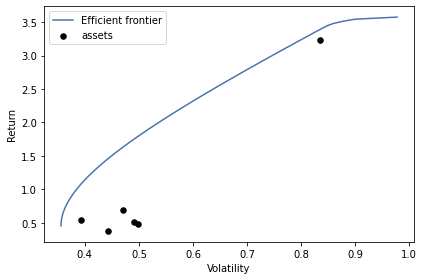

In [190]:
ef = EfficientFrontier(mu, Sigma, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax)
plt.show()




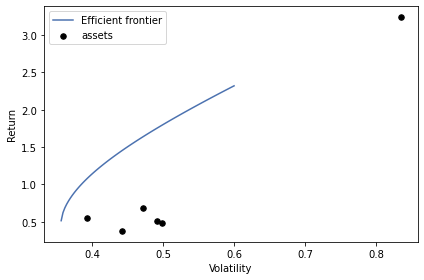

<AxesSubplot:xlabel='Volatility', ylabel='Return'>

In [191]:
risk_range = np.linspace(0.346, 0.60, 100)
plotting.plot_efficient_frontier(ef, ef_param="risk", ef_param_range=risk_range,
                                show_assets=True, showfig=True)

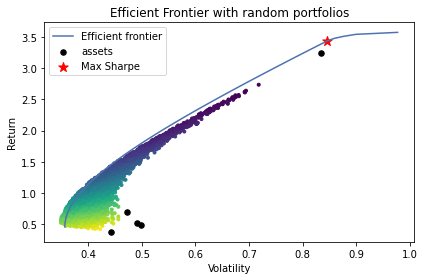

In [192]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ Sigma @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()